In [1]:
import datetime
import time
from odps import ODPS
from odps.df import DataFrame
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from functools import reduce
from tqdm.notebook import tqdm
import warnings
import json
import re
import math
# 模型训练及测试
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

# 画图
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['font.family']='sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)

In [2]:
def get_bin(sample_df, sample_df_raw, column):
    b = sorted(set([-np.inf
                    , np.quantile(sample_df_raw[column], 0)
                    , np.quantile(sample_df_raw[column], 0.1)
                    , np.quantile(sample_df_raw[column], 0.2)
                    , np.quantile(sample_df_raw[column], 0.3)
                    , np.quantile(sample_df_raw[column], 0.4)
                    , np.quantile(sample_df_raw[column], 0.5)
                    , np.quantile(sample_df_raw[column], 0.6)
                    , np.quantile(sample_df_raw[column], 0.7)
                    , np.quantile(sample_df_raw[column], 0.8)
                    , np.quantile(sample_df_raw[column], 0.9)
                    , np.inf]))
    return pd.cut(sample_df[column], b)


def get_metrics(sample_df, column, y):
    global total, bad, good, badratio
    column_df = sample_df.groupby(column+'_bin')[y].agg([np.size, np.sum]).reset_index()
    column_df.columns = ['分箱', '个数', '坏样本']
    column_df['特征'] = column
    column_df['整体个数'] = total
    column_df['整体坏样本'] = bad
    column_df['整体好样本'] = good
    column_df['整体badratio'] = badratio
    column_df['好样本'] = column_df['个数'] - column_df['坏样本']
    column_df['badratio'] = column_df['坏样本']/column_df['个数']
    column_df['累计badrate'] = column_df['坏样本'].cumsum()/bad
    column_df['累计goodrate'] = column_df['好样本'].cumsum()/good
    column_df['KS分量'] = abs(column_df['累计badrate'] - column_df['累计goodrate'])
    column_df['KS'] = max(column_df['KS分量'])
    column_df['WOE'] = np.log((column_df['好样本']/good)/(column_df['坏样本']/bad))
    column_df['IV'] = sum((column_df['好样本']/good - column_df['坏样本']/bad)*column_df['WOE'])
    column_df['lift'] = column_df['badratio']/badratio
    column_df['minlift'] = min(column_df['lift'])
    column_df['maxlift'] = max(column_df['lift'])
    column_df['上累计lift'] = (column_df['坏样本'].cumsum()/column_df['个数'].cumsum())/badratio
    column_df['下累计lift'] = ((bad-column_df['坏样本'].cumsum())/(total-column_df['个数'].cumsum()))/badratio
    column_df['max上累计lift'] = max(column_df['上累计lift'])
    column_df['max下累计lift'] = max(column_df['下累计lift'])
    return column_df[[
        '特征'
        ,'分箱'
        ,'整体个数'
        ,'整体坏样本'
        ,'整体好样本'
        ,'整体badratio'
        ,'个数','坏样本'
        ,'好样本'
        ,'badratio'
        ,'累计badrate'
        ,'累计goodrate'
        ,'KS分量'
        ,'KS'
        ,'WOE'
        ,'IV'
        ,'lift'
        ,'minlift'
        ,'maxlift'
        ,'上累计lift'
        ,'下累计lift'
        ,'max上累计lift'
        ,'max下累计lift'
]]


def datediff(t1, t2):
    try:
        _t1 = datetime.datetime.strptime(str(t1),"%Y-%m-%d %H:%M:%S")
        _t2 = datetime.datetime.strptime(str(t2),"%Y-%m-%d %H:%M:%S")
    except:
        return -9999
    return (_t1 - _t2).days

# 导入

In [3]:
# 导入数据
tmp_repayinfo_shl = pd.read_csv('./raw_data/套现特征_20211224.txt')

In [4]:
tmp_repayinfo_shl.shape

(62616, 120)

# 调整

In [5]:
# 缺失值与标签
repayinfo = tmp_repayinfo_shl.copy(deep=True)
repayinfo.replace('\\N', np.nan, inplace=True)
repayinfo['d1amo'] = repayinfo['d1amo'].astype('float64')
repayinfo['d3amo'] = repayinfo['d3amo'].astype('float64')
repayinfo['d7amo'] = repayinfo['d7amo'].astype('float64')
repayinfo['d15amo'] = repayinfo['d15amo'].astype('float64')
repayinfo['d30amo'] = repayinfo['d30amo'].astype('float64')
repayinfo['d1amosum'] = repayinfo['d1amosum'].astype('float64')
repayinfo['d3amosum'] = repayinfo['d3amosum'].astype('float64')
repayinfo['d7amosum'] = repayinfo['d7amosum'].astype('float64')
repayinfo['d15amosum'] = repayinfo['d15amosum'].astype('float64')
repayinfo['d30amosum'] = repayinfo['d30amosum'].astype('float64')

In [6]:
# 逾期标签
repayinfo['d1target'] = repayinfo.d1amo.map(lambda x: 1 if x>0 else 0)
repayinfo['d3target'] = repayinfo.d3amo.map(lambda x: 1 if x>0 else 0)
repayinfo['d7target'] = repayinfo.d7amo.map(lambda x: 1 if x>0 else 0)
repayinfo['d15target'] = repayinfo.d15amo.map(lambda x: 1 if x>0 else 0)
repayinfo['d30target'] = repayinfo.d30amo.map(lambda x: 1 if x>0 else 0)

In [7]:
# 特征及target
ftr = [col for col in repayinfo.columns if re.match('[\u4e00-\u9fa5]+', col)]
target = 'd15target'
sample_valid = repayinfo[~repayinfo[target.replace('target','')+'amosum'].isna()].copy(deep=True)

# 分箱及指标

In [7]:
total = sample_valid.shape[0]
bad = sample_valid[sample_valid[target]==1].shape[0]
good = sample_valid[sample_valid[target]==0].shape[0]
badratio = bad/total

bin_df = pd.DataFrame(columns=[])
for col in tqdm(ftr):    
    # 分箱
    sample_valid[col+'_bin'] = get_bin(sample_valid, sample_valid, col)
    # 重要指标
    col_df = get_metrics(sample_valid, col, target)
    bin_df = bin_df.append(col_df, ignore_index=True)

  0%|          | 0/84 [00:00<?, ?it/s]

In [8]:
# bin_df.to_csv('./output/bin_df_d15_20211224.csv', index=0)

# 特征选择

In [9]:
sift_df = bin_df.groupby('特征')['KS','IV','minlift','maxlift'].agg('max').reset_index()

In [10]:
# sift_df.sort_values(by='maxlift', ascending=False)

# sift_df.sort_values(by='IV', ascending=False)

# sift_df.sort_values(by='KS', ascending=False)

In [11]:
selection = lambda x: True if (x['maxlift']>=1.6 or x['minlift']<=0.5 and x['minlift']!=0) or (x['IV']>=0.1 and x['IV']!=np.inf) else False
# selection = lambda x: True if (x['maxlift']>=1.6) or (x['IV']>=0.1 and x['IV']!=np.inf) else False
select_list = sift_df[sift_df.apply(selection, axis=1)]['特征'].tolist()
select_list

['套现下单类目_180天内数码成功下单金额',
 '套现下单类目_7天内手机成功下单笔数',
 '套现下单类目_7天内手机成功下单金额',
 '套现下单类目_90天内数码成功下单金额',
 '正常下单类目_180天内非数码与饰品腕表成功商品分期下单一级类目数',
 '正常下单类目_180天内非数码与饰品腕表成功商品分期下单二级类目数',
 '正常下单类目_180天内非数码与饰品腕表成功商品分期下单金额',
 '正常下单类目_30天内非数码与饰品腕表成功商品分期下单一级类目数',
 '正常下单类目_7天内非数码与饰品腕表成功商品分期下单金额',
 '正常下单类目_90天内非数码与饰品腕表成功商品分期下单一级类目数',
 '正常下单类目_90天内非数码与饰品腕表成功商品分期下单二级类目数',
 '正常下单类目_90天内非数码与饰品腕表成功商品分期下单金额',
 '现金申请失败_7天内现金分期评分刚性拒绝笔数',
 '现金申请失败_7天内现金分期评分刚性拒绝金额',
 '现金申请失败_7天内现金分期风控拒绝笔数',
 '疑似非本人收货_7天内注册手机号关联收货城市个数',
 '疑似非本人收货_7天内注册手机号关联收货省份个数']

In [12]:
corr = sample_valid[select_list].corr()
# corr.to_csv('./output/corr_20211224.csv')

In [13]:
# 选相关性高的
corr_pair_dict = defaultdict(list)
for col, record in corr.to_dict().items():
    for index, value in record.items():
        if value>=0.8 and value!=1:
            corr_pair_dict[col].append(index)

# 拆dict
corr_pair_list = []
for k, v in corr_pair_dict.items():
    if set([k]+v) not in [set(x) for x in corr_pair_list]:
        corr_pair_list.append([k]+v)

# 加指标
corr_pair_list_metric = []
for i in corr_pair_list:
    corr_pair_list_metric.append([(j, max(bin_df[bin_df['特征']==j]['IV'])) for j in i])
    
# 筛指标最高的
selected = set()
for i in corr_pair_list_metric:
    s = sorted(i, key=lambda x: x[1], reverse=True)
    selected.add(s[0][0])
    
selected

{'套现下单类目_180天内数码成功下单金额',
 '套现下单类目_7天内手机成功下单笔数',
 '正常下单类目_180天内非数码与饰品腕表成功商品分期下单二级类目数',
 '正常下单类目_180天内非数码与饰品腕表成功商品分期下单金额',
 '正常下单类目_90天内非数码与饰品腕表成功商品分期下单一级类目数',
 '现金申请失败_7天内现金分期评分刚性拒绝笔数',
 '疑似非本人收货_7天内注册手机号关联收货城市个数'}

In [14]:
selected_df = bin_df[bin_df['特征'].isin(selected)][['特征','分箱','个数','KS','IV','lift','minlift','maxlift']]
# selected_df.to_csv('./output/metrics_20211224.csv', index=0)

In [15]:
woe_dict = {row['特征']+'|'+str(row['分箱']): row['WOE'] for i, row in bin_df.iterrows()}

for col in tqdm(selected):
    sample_valid[col+'_woe'] = sample_valid.apply(lambda x: woe_dict[col+'|'+str(x[col+'_bin'])], axis=1)

  0%|          | 0/7 [00:00<?, ?it/s]

# 模型训练及测试

In [16]:
x = sample_valid[[x+'_woe' for x in selected]]
y = sample_valid[target]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 0)

# 采样
# rsp = RandomOverSampler(random_state=0) # 0.65
# rsp = SMOTE(random_state=0) # 0.65
# rsp = ADASYN(random_state=0) # 0.65
# rsp = RandomUnderSampler(random_state=0) # 0.64
# rsp = ClusterCentroids(random_state=0) # 0.6
# rsp = NearMiss(version=1) # 0.51 0.53 0.58
rsp = SMOTEENN(random_state=0) # 0.65
# rsp = SMOTETomek(random_state=0) # 0.65

x_resample, y_resample = rsp.fit_resample(x_train, y_train)
Counter(y_resample)

Counter({0: 27729, 1: 22615})

In [17]:
model = LogisticRegression(random_state=0)
clf = model.fit(x_resample,y_resample)
# 预测标签
y_pred  = clf.predict(x_test)
print("测试集的平均正确率：{}".format(clf.score(x_test,y_test)))

# 计算回归值，取值小于0，表示p(y=1) <0.5,则该处标签属于1，否则属于0
y_pred1 = clf.decision_function(x_test)

测试集的平均正确率：0.6959715734419292


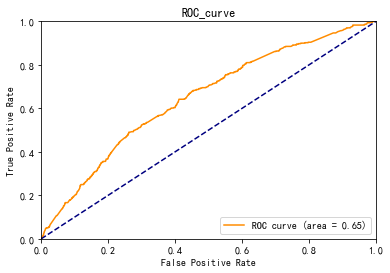

In [18]:
## 绘制ROC曲线并计算AUC的值
fpr, tpr, threshold = roc_curve(y_test,y_pred1)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

# 计算得分

In [19]:
# 系数值
coe = clf.coef_

### 计算得分
# score = offset-factor*log(odds)
# 约定：当odds增加一倍，分数减少20分；当odds = 1,分数为600分
factor = 20 /np.log(2)
offset = 600
# 分数facor*woe_i*beta

In [20]:
sample_valid['score'] = x.apply(lambda x: 600-factor*np.dot(list(x), coe[0]), axis=1)

In [21]:
col_res = list(sample_valid.iloc[:,:36].columns)+list(selected)+[x+'_bin' for x in selected]+['score']
# sample_valid[col_res].to_csv('./output/repayinfo_score_20211224.csv', index=0)

In [22]:
# 计算变量分
coe_dict = dict(zip(x.columns, coe[0]))

selected_score_list = []
for k, v in woe_dict.items():
    tmp_k = k.split('|')[0]
    if tmp_k in selected:
        v_res = factor*v*coe_dict[tmp_k+'_woe']
        selected_score_list.append(k.split('|')+[v_res])

In [23]:
feature_score = pd.DataFrame(selected_score_list, columns=['特征','分箱','分数'])
# feature_score.to_csv('./output/feature_score_20211224.csv', index=0)

In [24]:
# sample_valid[sample_valid['score']>640]['usermobile'].drop_duplicates().to_csv('./output/good_shl.csv', index=0)

# OOT

## 导入

In [25]:
# 导入数据
tmp_repayinfo_shl2 = pd.read_csv('./raw_data/套现特征OOT.txt')

In [26]:
tmp_repayinfo_shl2.shape

(100468, 120)

## 调整

In [27]:
# 缺失值与标签
repayinfo2 = tmp_repayinfo_shl2.copy(deep=True)
repayinfo2.replace('\\N', np.nan, inplace=True)
repayinfo2['d1amo'] = repayinfo2['d1amo'].astype('float64')
repayinfo2['d3amo'] = repayinfo2['d3amo'].astype('float64')
repayinfo2['d7amo'] = repayinfo2['d7amo'].astype('float64')
repayinfo2['d15amo'] = repayinfo2['d15amo'].astype('float64')
repayinfo2['d30amo'] = repayinfo2['d30amo'].astype('float64')
repayinfo2['d1amosum'] = repayinfo2['d1amosum'].astype('float64')
repayinfo2['d3amosum'] = repayinfo2['d3amosum'].astype('float64')
repayinfo2['d7amosum'] = repayinfo2['d7amosum'].astype('float64')
repayinfo2['d15amosum'] = repayinfo2['d15amosum'].astype('float64')
repayinfo2['d30amosum'] = repayinfo2['d30amosum'].astype('float64')

In [28]:
# 逾期标签
repayinfo2['d1target'] = repayinfo2.d1amo.map(lambda x: 1 if x>0 else 0)
repayinfo2['d3target'] = repayinfo2.d3amo.map(lambda x: 1 if x>0 else 0)
repayinfo2['d7target'] = repayinfo2.d7amo.map(lambda x: 1 if x>0 else 0)
repayinfo2['d15target'] = repayinfo2.d15amo.map(lambda x: 1 if x>0 else 0)
repayinfo2['d30target'] = repayinfo2.d30amo.map(lambda x: 1 if x>0 else 0)

## 分箱及woe

In [29]:
sample_valid2 = repayinfo2[~repayinfo2[target.replace('target','')+'amosum'].isna()].copy(deep=True)

for col in tqdm(selected):    
    # 分箱
    sample_valid2[col+'_bin'] = get_bin(sample_valid2, sample_valid, col)
    sample_valid2[col+'_woe'] = sample_valid2.apply(lambda x: woe_dict[col+'|'+str(x[col+'_bin'])], axis=1)

  0%|          | 0/7 [00:00<?, ?it/s]

## 测试

In [30]:
x2 = sample_valid2[[x+'_woe' for x in selected]]
y2 = sample_valid2[target]

In [31]:
y_pred2  = clf.predict(x2)
print("测试集的平均正确率：{}".format(clf.score(x2,y2)))

# 计算回归值，取值小于0，表示p(y=1) <0.5,则该处标签属于1，否则属于0
y_pred12 = clf.decision_function(x2)

测试集的平均正确率：0.6982999184304297


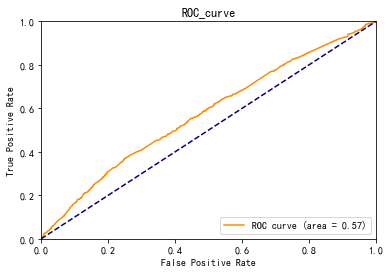

In [32]:
## 绘制ROC曲线并计算AUC的值
fpr, tpr, threshold = roc_curve(y2,y_pred12)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

## 计算得分

In [33]:
sample_valid2['score'] = x2.apply(lambda x: 600-factor*np.dot(list(x), coe[0]), axis=1)

In [34]:
# sample_valid2[col_res].to_csv('./output/repayinfo_score_oot_20211224.csv', index=0)